In [1]:
import torch
import numpy as np

class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=2) #torch.Size([233, 8, 158, 158])
        self.pool1 = torch.nn.MaxPool2d((2,2), stride=2)   #torch.Size([233, 8, 79, 79])
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1)   #torch.Size([233, 16, 75, 75])
        self.pool2 = torch.nn.MaxPool2d((2,2), stride=2)   #torch.Size([233, 16, 37, 37])
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1)   #torch.Size([233, 32, 33, 33])
        self.pool3 = torch.nn.MaxPool2d((2,2), stride=2)   #torch.Size([233, 32, 16, 16])
        self.conv4 = torch.nn.Conv2d(in_channels=32, out_channels=50, kernel_size=5, stride=1)   #torch.Size([233, 50, 12, 12])
        self.pool4 = torch.nn.MaxPool2d((2,2), stride=2)   #torch.Size([233, 50, 6, 6])
        self.fc1 = torch.nn.Linear(in_features=1800,out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100,out_features=3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.pool4(x)
        x = self.fc1(x.view(-1, 1800))
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.softmax(x,dim=1)
        return x

In [2]:
PATH='C:/Users/Administrator/program/model.pth'
model=MyModel()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [3]:
import pandas as pd
from PIL import Image

path="C:/Users/Administrator/program/data/"
data = pd.read_csv(path+"test.csv") 
file=np.array(data["file"])
source=np.array(data["source"])
p_type=np.array(data["type"])

n1=data.shape[0]
size=320
p_array=np.empty((n1,size,size,3))

for i in range(n1) :
        path_img=path+source[i]+file[i]
        image_i=np.array(Image.open(path_img).convert("RGB").resize((size,size)))
        p_array[i]=image_i

p_array=torch.tensor(p_array).permute(0,3,1,2).float()

p_type[p_type=="nature"]=0
p_type[p_type=="board"]=1
p_type[p_type=="paper"]=2
p_type[p_type=="file"]=2
#由于本实验没有设置其它类型，打标签时也没有打其他标签所以无其他值处理
p_type=torch.tensor(p_type.astype(int))

In [10]:
#混淆矩阵
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[int(p), int(t)] += 1
    return conf_matrix

#测试集上的混淆矩阵的效果
x=range(9,1000,10)
accList=[]
adjaccList=[]
for i in x:
    PATH="C:/Users/Administrator/program/TempModel/temp"+str(i)+".pth"
    model=MyModel()
    model.load_state_dict(torch.load(PATH))
    y_pred=torch.argmax(model(p_array),dim=1)
    conf_matrix=confusion_matrix(y_pred, p_type, np.zeros((3,3)))
    acc=(conf_matrix[0,0]+conf_matrix[1,1]+conf_matrix[2,2])/p_array.shape[0]
    adjustedacc=(sum(sum(conf_matrix[0:2,0:2]))+conf_matrix[2,2])/p_array.shape[0]
    accList.append(acc)
    adjaccList.append(adjustedacc)

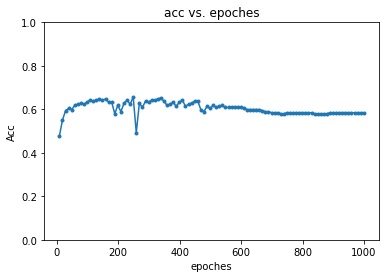

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

plt.plot(x, accList, '.-')
plt.xlabel('epoches')
plt.ylim(0,1)
plt.ylabel('Acc')
plt.title("acc vs. epoches")
plt.show()
plt.savefig("C:/Users/Administrator/program/acc.jpg")


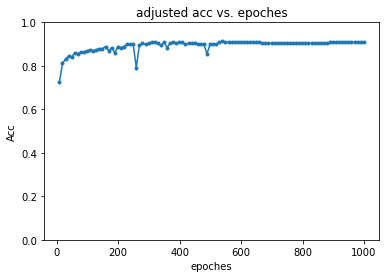

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(x, adjaccList, '.-')
plt.xlabel('epoches')
plt.ylim(0,1)
plt.ylabel('Acc')
plt.title("adjusted acc vs. epoches")
plt.show()
plt.savefig("C:/Users/Administrator/program/acc.jpg")


In [7]:
#测试集上的混淆矩阵的效果
PATH="C:/Users/Administrator/program/model.pth"
model=MyModel()
model.load_state_dict(torch.load(PATH))
y_pred=torch.argmax(model(p_array),dim=1)
conf_matrix=pd.DataFrame(confusion_matrix(y_pred, p_type, np.zeros((3,3))))
conf_matrix.columns = ['nature_true','board_true','file&paper_true']
conf_matrix.index = ['nature_pred','board_pred','file&paper_pred']
conf_matrix

,nature_true,board_true,file&paper_true
nature_pred,17.0,34.0,7.0
board_pred,33.0,42.0,7.0
file&paper_pred,1.0,4.0,62.0
